In [23]:
import yfinance as yf
import pandas as pd
import os

In [24]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [25]:
sp500.index = pd.to_datetime(sp500.index)

/var/folders/kj/zz7bccj90m72x8sl1mkb9l380000gn/T/ipykernel_56637/318495744.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sp500.index = pd.to_datetime(sp500.index)


In [26]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-08-11 00:00:00-04:00,6389.669922,6407.250000,6364.060059,6373.450195,4652400000,0.0,0.0
2025-08-12 00:00:00-04:00,6395.169922,6446.549805,6385.759766,6445.759766,5135300000,0.0,0.0
2025-08-13 00:00:00-04:00,6462.669922,6480.279785,6445.020020,6466.580078,5195950000,0.0,0.0


<Axes: xlabel='Date'>

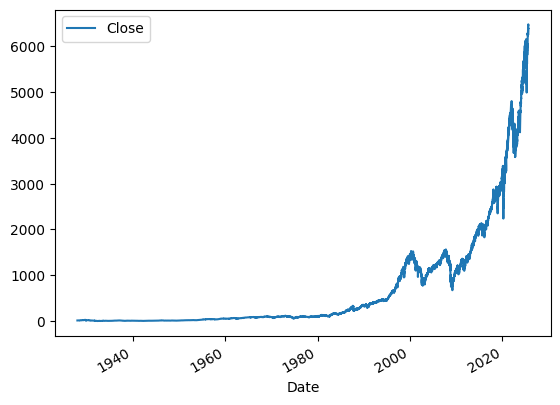

In [27]:
sp500.plot.line(y="Close", use_index=True)


In [28]:
del sp500["Dividends"]
del sp500["Stock Splits"]

**Setting up Target for Machine Learning**

In [29]:
sp500["Tomorrow"] = sp500["Close"].shift(-1) # Creating tomorrow's price as today's market close price

In [30]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int) # checking is tomorrow's price is higher than today's close price

**Training initial ML model**

In [31]:
from sklearn.ensemble import RandomForestClassifier #RandomForest is less prone to overfitting

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"]) #using predictors to predict the target

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,100
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
from sklearn.metrics import precision_score #error/accuracy metric (when we said the stock price would go up, how often did it actually go up)

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5737704918032787

<Axes: xlabel='Date'>

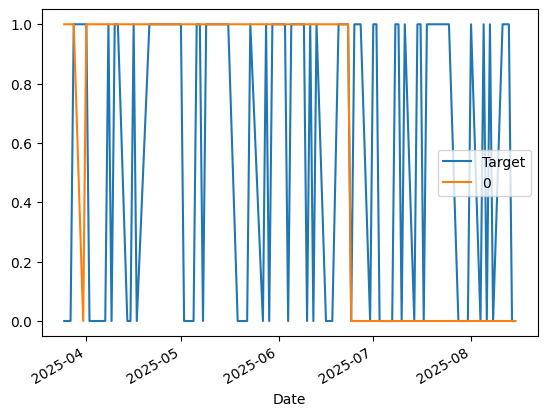

In [33]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

**Building Backtesting System**

In [34]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [35]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = [] # list of dataframes of predictions for a single year

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [36]:
predictions = backtest(sp500, model, predictors)


In [37]:
predictions["Predictions"].value_counts()


Predictions
0    12431
1     9591
Name: count, dtype: int64

In [38]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5202794286310083

In [39]:
predictions["Target"].value_counts()

Target
1    11606
0    10416
Name: count, dtype: int64

In [40]:
predictions["Target"].value_counts() / predictions.shape[0] # divided by total rows to give percentage


Target
1    0.527018
0    0.472982
Name: count, dtype: float64

**Adding Additional Predictors**

In [41]:
horizons = [2,5,60,250,1000] # Rolling mean in the last 2 days, 5 days, etc.
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [42]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])


In [43]:
sp500


,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1931-12-29 00:00:00-05:00,7.960000,7.960000,7.960000,7.960000,0,8.100000,1,1.012723,1.0,0.996994,3.0,0.821282,24.0,0.582074,105.0,0.394305,521.0
1931-12-30 00:00:00-05:00,8.100000,8.100000,8.100000,8.100000,0,8.120000,1,1.008717,2.0,1.019381,3.0,0.837787,25.0,0.593657,105.0,0.401432,521.0
1931-12-31 00:00:00-05:00,8.120000,8.120000,8.120000,8.120000,0,7.560000,0,1.001233,2.0,1.017544,4.0,0.842149,25.0,0.596489,105.0,0.402615,522.0
1932-01-04 00:00:00-05:00,7.560000,7.560000,7.560000,7.560000,0,7.550000,0,0.964286,1.0,0.956962,3.0,0.785781,25.0,0.556754,104.0,0.375034,522.0
1932-01-05 00:00:00-05:00,7.550000,7.550000,7.550000,7.550000,0,8.080000,1,0.999338,0.0,0.960804,3.0,0.787963,24.0,0.557255,104.0,0.374726,521.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-11 00:00:00-04:00,6389.669922,6407.250000,6364.060059,6373.450195,4652400000,6445.759766,1,0.998746,1.0,1.003783,2.0,1.038191,34.0,1.087004,143.0,1.328752,528.0
2025-08-12 00:00:00-04:00,6395.169922,6446.549805,6385.759766,6445.759766,5135300000,6466.580078,1,1.005641,1.0,1.010506,3.0,1.048464,34.0,1.098512,143.0,1.343268,529.0
2025-08-13 00:00:00-04:00,6462.669922,6480.279785,6445.020020,6466.580078,5195950000,6468.540039,1,1.001612,2.0,1.009922,3.0,1.050404,34.0,1.101285,143.0,1.347026,530.0


In [44]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [45]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [47]:
predictions = backtest(sp500, model, new_predictors)


In [48]:
predictions["Predictions"].value_counts()


Predictions
0.0    17794
1.0     3228
Name: count, dtype: int64

In [49]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5947955390334573

In [50]:
predictions["Target"].value_counts() / predictions.shape[0]


Target
1    0.529683
0    0.470317
Name: count, dtype: float64

In [51]:
predictions


,Target,Predictions
Date,,
1942-01-07 00:00:00-05:00,0,0.0
1942-01-08 00:00:00-05:00,0,0.0
1942-01-09 00:00:00-05:00,0,0.0
1942-01-12 00:00:00-05:00,1,0.0
1942-01-13 00:00:00-05:00,0,0.0
...,...,...
2025-08-11 00:00:00-04:00,1,0.0
2025-08-12 00:00:00-04:00,1,0.0
2025-08-13 00:00:00-04:00,1,0.0


In [52]:
from sklearn.metrics import accuracy_score
accuracy_score(predictions["Target"], predictions["Predictions"])

0.4994291694415374

In [53]:
from sklearn.metrics import classification_report
print(classification_report(predictions["Target"], predictions["Predictions"]))


              precision    recall  f1-score   support

           0       0.48      0.87      0.62      9887
           1       0.59      0.17      0.27     11135

    accuracy                           0.50     21022
   macro avg       0.54      0.52      0.44     21022
weighted avg       0.54      0.50      0.43     21022



In [54]:
from sklearn.metrics import roc_auc_score, roc_curve

y_true = predictions["Target"]
y_scores = model.predict_proba(sp500[new_predictors])[:,1]  # probabilities

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [21022, 23522]

/var/folders/kj/zz7bccj90m72x8sl1mkb9l380000gn/T/ipykernel_56637/2321206952.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Predicted_Signal"] = predictions["Predictions"]
/var/folders/kj/zz7bccj90m72x8sl1mkb9l380000gn/T/ipykernel_56637/2321206952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Strategy_Return"] = sp500["Close"].pct_change() * sp500["Predicted_Signal"].shift(1)


<Axes: title={'center': 'Strategy Cumulative Returns'}, xlabel='Date'>

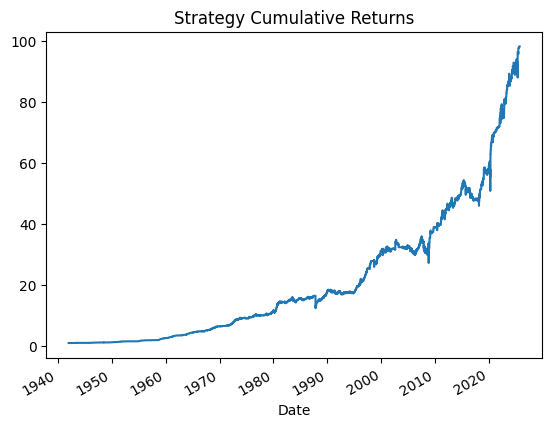

In [55]:
sp500["Predicted_Signal"] = predictions["Predictions"]
sp500["Strategy_Return"] = sp500["Close"].pct_change() * sp500["Predicted_Signal"].shift(1)
cumulative_return = (1 + sp500["Strategy_Return"]).cumprod()
cumulative_return.plot(title="Strategy Cumulative Returns")


In [56]:
cumulative_return = (1 + sp500["Strategy_Return"]).cumprod()
total_return = cumulative_return.iloc[-1] - 1
print(f"Total cumulative return: {total_return:.2%}")


Total cumulative return: 9724.32%


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import schedule
import time
import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

class SP500Predictor:
    def __init__(self):
        self.model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
        self.predictors = ["Close", "Volume", "Open", "High", "Low"]
        self.new_predictors = []
        self.horizons = [2, 5, 60, 250, 1000]
        self.sp500_data = None
        
    def fetch_latest_data(self, period="max"):
        """Fetch the latest S&P 500 data"""
        print("Fetching latest S&P 500 data...")
        ticker = yf.Ticker("^GSPC")
        data = ticker.history(period=period)
        
        # Reset index to make Date a column
        data = data.reset_index()
        data = data.set_index("Date")
        
        return data
    
    def prepare_features(self, data):
        """Prepare all features including rolling averages and trends"""
        # Create target variable
        data = data.copy()
        data["Tomorrow"] = data["Close"].shift(-1)
        data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)
        
        # Filter data from 1990 onwards
        data = data.loc["1990-01-01":].copy()
        
        # Create new predictors with different horizons
        new_predictors = []
        
        for horizon in self.horizons:
            rolling_averages = data.rolling(horizon).mean()
            
            ratio_column = f"Close_Ratio_{horizon}"
            data[ratio_column] = data["Close"] / rolling_averages["Close"]
            
            trend_column = f"Trend_{horizon}"
            data[trend_column] = data.shift(1).rolling(horizon).sum()["Target"]
            
            new_predictors += [ratio_column, trend_column]
        
        # Drop rows with NaN values (except Tomorrow column)
        data = data.dropna(subset=data.columns[data.columns != "Tomorrow"])
        
        self.new_predictors = new_predictors
        return data
    
    def train_model(self, data):
        """Train the model on historical data"""
        print("Training model on historical data...")
        
        # Use all available data except the last row for training
        train_data = data.iloc[:-1].copy()
        
        # Combine basic and new predictors
        all_predictors = self.predictors + self.new_predictors
        
        # Train the model
        self.model.fit(train_data[all_predictors], train_data["Target"])
        print(f"Model trained on {len(train_data)} data points")
        
        return all_predictors
    
    def predict_tomorrow(self, data):
        """Make prediction for tomorrow based on today's data"""
        # Get the latest data point
        latest_data = data.iloc[-1:].copy()
        
        # Combine all predictors
        all_predictors = self.predictors + self.new_predictors
        
        # Make prediction using probability
        pred_proba = self.model.predict_proba(latest_data[all_predictors])[:, 1]
        
        # Apply threshold (>=0.6 for UP, <0.6 for DOWN)
        prediction = 1 if pred_proba[0] >= 0.6 else 0
        confidence = pred_proba[0]
        
        return prediction, confidence
    
    def get_current_price_info(self):
        """Get current S&P 500 price information"""
        ticker = yf.Ticker("^GSPC")
        info = ticker.history(period="1d")
        if not info.empty:
            current_price = info['Close'].iloc[-1]
            return current_price
        return None
    
    def daily_prediction(self):
        """Main function to make daily predictions"""
        try:
            print(f"\n{'='*50}")
            print(f"S&P 500 Daily Prediction - {datetime.date.today()}")
            print(f"{'='*50}")
            
            # Fetch latest data
            raw_data = self.fetch_latest_data()
            
            # Prepare features
            self.sp500_data = self.prepare_features(raw_data)
            
            # Train model
            predictors = self.train_model(self.sp500_data)
            
            # Make prediction
            prediction, confidence = self.predict_tomorrow(self.sp500_data)
            
            # Get current price
            current_price = self.get_current_price_info()
            
            # Display results
            direction = "UP ⬆️" if prediction == 1 else "DOWN ⬇️"
            print(f"Current S&P 500 Price: {current_price:.2f}")
            print(f"Prediction for Tomorrow: {direction}")
            print(f"Confidence Score: {confidence:.3f}")
            print(f"Threshold Used: 0.600")
            
            if confidence >= 0.8:
                print("🔥 HIGH CONFIDENCE prediction!")
            elif confidence >= 0.6:
                print("✅ MEDIUM CONFIDENCE prediction")
            else:
                print("⚠️  LOW CONFIDENCE prediction")
            
            print(f"{'='*50}\n")
            
            return prediction, confidence
            
        except Exception as e:
            print(f"Error making prediction: {str(e)}")
            return None, None

def run_daily_predictions():
    """Function to run predictions on schedule"""
    predictor = SP500Predictor()
    
    # Make immediate prediction
    print("Making initial prediction...")
    predictor.daily_prediction()
    
    # Schedule daily predictions at 9:00 AM (market open)
    schedule.every().day.at("09:00").do(predictor.daily_prediction)
    
    print("Scheduler started. Predictions will run daily at 9:00 AM.")
    print("Press Ctrl+C to stop the scheduler.")
    
    # Keep the scheduler running
    while True:
        schedule.run_pending()
        time.sleep(60)  # Check every minute

def make_single_prediction():
    """Function to make a single prediction without scheduling"""
    predictor = SP500Predictor()
    return predictor.daily_prediction()

# Example usage:
if __name__ == "__main__":
    # For a single prediction, uncomment this:
    make_single_prediction()
    
    # For scheduled daily predictions, uncomment this:
    # run_daily_predictions()


S&P 500 Daily Prediction - 2025-08-16
Fetching latest S&P 500 data...
Training model on historical data...
Model trained on 7971 data points
Current S&P 500 Price: 6449.80
Prediction for Tomorrow: DOWN ⬇️
Confidence Score: 0.465
Threshold Used: 0.600
⚠️  LOW CONFIDENCE prediction



In [ ]:
predictions = backtest(sp500, model, new_predictors)


NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(predictions["Target"], predictions["Predictions"])


NameError: name 'predictions' is not defined